In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import os
import config as cfg
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
data = pd.read_csv(os.path.join(cfg.DATA_DIR, 'dataset_assignment_2021.csv'), parse_dates=['created_at', 'user_first_visit', 'user_birthyear'])
data.head()

,Unnamed: 0,created_at,payment_amount,user_id,fx_rate,mid_market_fx_rate,delivery_option,delivery_option_fee,from_country,to_country,from_currency,to_currency,user_nationality,user_language,user_first_visit,user_birthyear
0,0,2018-05-01 07:22:46,294.23,51234277167,5.54802,5.44816,standard,0.00,UK,Romania,GBP,RON,romanian,English,2013-07-01 12:13:48,1979-01-01 00:00:00
1,1,2018-05-01 07:20:14,294.15,51234277167,5.54944,5.44955,standard,0.00,UK,Romania,GBP,RON,romanian,English,2013-07-01 12:13:48,1979-01-01 00:00:00
2,2,2019-03-11 15:37:08,50.00,51234280953,5.71204,5.54068,standard,0.99,UK,Romania,GBP,RON,romanian,Romanian,2013-07-24 10:20:45,1989-01-01 00:00:00
3,3,2019-02-01 10:29:58,100.00,51234280953,5.53169,5.38233,standard,0.99,UK,Romania,GBP,RON,romanian,Romanian,2013-07-24 10:20:45,1989-01-01 00:00:00
4,4,2019-04-10 18:35:48,700.00,51234280953,5.66832,5.55779,standard,0.99,UK,Romania,GBP,RON,romanian,Romanian,2013-07-24 10:20:45,1989-01-01 00:00:00


# EDA and Outlier Analysis/Removal

- Want to see how the data looks, are there any outliers, etc.

Using streamlit for EDA, to always have the EDA on the side to look at it.

In [3]:
 # My recomendaation would be to launch the streamlit from the terminaal with the same commant

! streamlit run EDA.py -- --data_path $cfg.DATA_DIR/dataset_assignment_2021.csv --preprocess --output_path $cfg.DATA_DIR/updated_data.csv


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.168:8501

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701748 entries, 0 to 1701747
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   created_at               datetime64[ns]
 1   payment_amount           float64       
 2   user_id                  int64         
 3   fx_rate                  float64       
 4   mid_market_fx_rate       float64       
 5   delivery_option          object        
 6   delivery_option_fee      float64       
 7   from_country             object        
 8   to_country               object        
 9   from_currency            object        
 10  to_currency              object        
 11  user_nationality         object        
 12  user_language            object        
 13  user_first_visit         datetime64[ns]
 14  user_birthyear           obj

There are definetly outliers in the data, so I will remove them.

In [4]:
path = os.path.join(cfg.DATA_DIR, 'updated_data.csv')
data = pd.read_csv(path, parse_dates=['created_at', 'user_first_visit', 'create_at_date'])
data.head()

,created_at,payment_amount,user_id,fx_rate,mid_market_fx_rate,delivery_option,delivery_option_fee,from_country,to_country,from_currency,...,user_first_visit,user_birthyear,create_at_date,create_at_hour,month,day_of_week,fx_rate_difference,fx_rate_markup,days_since_first_visit,weeks_since_first_visit
0,2018-05-01 07:22:46,294.23,51234277167,5.54802,5.44816,standard,0.00,UK,Romania,GBP,...,2013-07-01 12:13:48,1979-01-01 00:00:00,2018-05-01,7,5,1,0.09986,1.832912,1764,252
1,2018-05-01 07:20:14,294.15,51234277167,5.54944,5.44955,standard,0.00,UK,Romania,GBP,...,2013-07-01 12:13:48,1979-01-01 00:00:00,2018-05-01,7,5,1,0.09989,1.832995,1764,252
2,2019-03-11 15:37:08,50.00,51234280953,5.71204,5.54068,standard,0.99,UK,Romania,GBP,...,2013-07-24 10:20:45,1989-01-01 00:00:00,2019-03-11,15,3,0,0.17136,3.092761,2056,293
3,2019-02-01 10:29:58,100.00,51234280953,5.53169,5.38233,standard,0.99,UK,Romania,GBP,...,2013-07-24 10:20:45,1989-01-01 00:00:00,2019-02-01,10,2,4,0.14936,2.775006,2018,288
4,2019-04-10 18:35:48,700.00,51234280953,5.66832,5.55779,standard,0.99,UK,Romania,GBP,...,2013-07-24 10:20:45,1989-01-01 00:00:00,2019-04-10,18,4,2,0.11053,1.988740,2086,298


In [6]:
def find_outliers(data: pd.DataFrame) -> bool:
    """
    Finding outliers using IQR method.
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

def remove_outliers(data: pd.DataFrame, 
                    columns: list) -> pd.DataFrame:
    """
    Removing numeric outliers.
    """
    df_clean = data.copy()
    for col in columns:
        if df_clean[col].dtype in ['int64', 'float64']:
            outliers = find_outliers(df_clean[col])
            df_clean = df_clean[~outliers]
    return df_clean

def check_outliers(data: pd.DataFrame, 
                   columns: list) -> pd.DataFrame:
    """
    Checking how the outliers look and their general stats. 
    """
    outlier_analysis = {}
    for col in columns:
        if data[col].dtype in ['int64', 'float64']:
            outliers = find_outliers(data[col])
            outlier_count = outliers.sum()
            outlier_percentage = (outlier_count / len(data)) * 100
            outlier_analysis[col] = {
                'outlier_count': outlier_count,
                'outlier_percentage': outlier_percentage,
                'min': data[col].min(),
                'max': data[col].max(),
                'mean': data[col].mean(),
                'median': data[col].median()
            }
    return outlier_analysis

In [7]:
outlier_cols = ['payment_amount', 'days_since_first_visit', 'weeks_since_first_visit']
analysis = check_outliers(data, outlier_cols)

In [8]:
for col, stats in analysis.items():
        print(f"\nOutlier Analysis for {col}:")
        print(f"Number of outliers: {stats['outlier_count']}")
        print(f"Percentage of outliers: {stats['outlier_percentage']:.2f}%")
        print(f"Minimum value: {stats['min']}")
        print(f"Maximum value: {stats['max']}")
        print(f"Mean: {stats['mean']:.2f}")
        print(f"Median: {stats['median']:.2f}")


Outlier Analysis for payment_amount:
Number of outliers: 139625
Percentage of outliers: 8.20%
Minimum value: 1.0
Maximum value: 50000.0
Mean: 612.10
Median: 300.00

Outlier Analysis for days_since_first_visit:
Number of outliers: 36526
Percentage of outliers: 2.15%
Minimum value: 0
Maximum value: 44168
Mean: 425.17
Median: 340.00

Outlier Analysis for weeks_since_first_visit:
Number of outliers: 36742
Percentage of outliers: 2.16%
Minimum value: 0
Maximum value: 6309
Mean: 60.32
Median: 48.00


In [9]:
data_clean = remove_outliers(data, outlier_cols)
path = os.path.join(cfg.DATA_DIR, 'cleaned_data.csv')
data_clean.to_csv(path, index=False)

In [49]:
 # My recomendaation would be to launch the streamlit from the terminaal with the same commant

! streamlit run EDA.py -- --data_path $path


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.168:8501

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522045 entries, 0 to 1522044
Data columns (total 23 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   created_at               1522045 non-null  object 
 1   payment_amount           1522045 non-null  float64
 2   user_id                  1522045 non-null  int64  
 3   fx_rate                  1522045 non-null  float64
 4   mid_market_fx_rate       1522045 non-null  float64
 5   delivery_option          1522045 non-null  object 
 6   delivery_option_fee      1522045 non-null  float64
 7   from_country             1522045 non-null  object 
 8   to_country               1522045 non-null  object 
 9   from_currency            1522045 non-null  object 
 10  to_currency              1522045 non-null  object 
 11  user_nationality    

# Clustering

General idea behind the clustering was to check if there any notable clusters, that would help with the analysis of the last two questions.

In [29]:
def mode(series):
    """Using it for categorical variable aggregation"""
    result = sts.mode(series)
    return int(result.__getattribute__('mode'))

def preprocess_data(df: pd.DataFrame, 
                    exclude_features: list= [],
                    categorical_features: list= []) -> tuple:
    """Preprocess the data for feature analysis."""
    
    # Select features
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_features = [f for f in numeric_features if f not in exclude_features]
    categorical_features = [f for f in categorical_features if f not in exclude_features]
    
    imputer = SimpleImputer(strategy='mean')
    df_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_features]), columns=numeric_features, index=df.index)
    
    if categorical_features:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(df[categorical_features])
        feature_names = encoder.get_feature_names_out(categorical_features)
        df_categorical = pd.DataFrame(encoded_features, 
                                      columns=feature_names,
                                      index=df.index)
        df_processed = pd.concat([df_numeric, df_categorical], axis=1)
    else:
        df_processed = df_numeric
    
    return df_processed, df_processed.columns, numeric_features

def aggregate_data(df, group_by_column, agg_dict, numeric_features):
    """Aggregate data based on specified column and aggregation dictionary."""
    df = df.groupby(group_by_column).agg(agg_dict).reset_index()
    
    scaler = StandardScaler()
    df_numeric = df[numeric_features]
    non_numeric_features = [col for col in df.columns if col not in numeric_features]
    df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_features, index=df.index)
    
    results_df = pd.concat([df[non_numeric_features], df_numeric_scaled], axis=1)
    
    return results_df


def analyze_feature_importance(data: pd.DataFrame, 
                               feature_names: list) -> pd.DataFrame:
    """Analyze feature importance using PCA."""
    pca = PCA()
    pca.fit(data)
    
    feature_importance = np.abs(pca.components_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.sum())
    
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(15, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.xlabel('Importance (%)')
    plt.ylabel('Feature')
    plt.show()
    
    return feature_importance_df

def select_features(feature_importance_df: pd.DataFrame, 
                    threshold: float=1.0) -> list:
    """Select features based on importance threshold."""
    selected_features = feature_importance_df[feature_importance_df['importance'] >= threshold]['feature'].tolist()
    print(f"Selected features: {selected_features}, with importance >= {threshold}")
    return selected_features

def elbow_method(data: pd.DataFrame, 
                 max_clusters: int=10) -> list:
    """
    Perform the elbow method to find the optimal number of clusters.
    Also could use silhouette score to find the optimal number of clusters, but 
    I chose to use the elbow method here, because it is more straightforward.
    
    There is a possible case where  there  could be more than 10 clusters, but for this analysis, I do not think it is needed.
    """
    
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    return inertias

def plot_elbow(inertias: list) -> None:
    """Plot the elbow curve."""
    plt.figure(figsize=(15, 10))
    plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
def perform_clustering(data, n_clusters):
    """Perform K-means clustering."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(data)

def plot_clusters_2d(data, labels):
    """Plot the clusters in 2D using PCA."""
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('User Clusters')
    plt.colorbar(scatter)
    plt.show()
    
def analyze_clusters(df, features, labels):
    """Analyze the characteristics of each cluster."""
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels
    
    for i in range(len(set(labels))):
        print(f"\nCluster {i}:")
        print(df_clustered[df_clustered['Cluster'] == i][features].describe())
        
    fig, axes = plt.subplots(len(features), 1, figsize=(12, 5*len(features)))
    for i, feature in enumerate(features):
        sns.boxplot(x='Cluster', y=feature, data=df_clustered, ax=axes[i] if len(features) > 1 else axes)
    plt.tight_layout()
    plt.show()
    
def clustering(data: pd.DataFrame,
                       save: bool) -> None:
    """Perform clustering analysis."""
    
    print("Available features:", data.columns.tolist())
    exclude_features = input("Enter features to exclude (comma-separated, press enter for none): ").split(',')
    exclude_features = [f.strip() for f in exclude_features if f.strip()]
    
    categorical_features = input("Enter categorical features (comma-separated, press enter if none): ").split(',')
    categorical_features = [f.strip() for f in categorical_features if f.strip()]
    
    df_processed, feature_names, numeric_features = preprocess_data(data, exclude_features, categorical_features)
    
    group_by_column = input("Enter the column to group by for aggregation: ")
    agg_dict = {col: 'mean' for col in df_processed.columns if col != group_by_column}
    for col in df_processed.columns:
        if col != group_by_column:
            if col in numeric_features:
                agg_dict[col] = 'mean'
            else:
                agg_dict[col] = mode
        
    df_aggregated = aggregate_data(df_processed, group_by_column, agg_dict, numeric_features)
    print(f"Aggregation complete. Shape after aggregation: {df_aggregated.shape}")
    
    feature_importance_df = analyze_feature_importance(df_aggregated.drop(columns=[group_by_column]), 
                                                       df_aggregated.drop(columns=[group_by_column]).columns)
    print(f"Feature Importance: {feature_importance_df}")
    
    threshold = float(input("Enter the importance threshold for feature selection (e.g., 1.0): "))
    selected_features = select_features(feature_importance_df, threshold)
    selected_data = df_aggregated[selected_features]
    
    inertias = elbow_method(selected_data)
    plot_elbow(inertias)
    
    n_clusters = int(input("Enter the number of clusters based on the elbow curve: "))
    labels = perform_clustering(selected_data, n_clusters)
    plot_clusters_2d(selected_data, labels)
    
    analyze_clusters(df_aggregated, selected_features, labels)
    
    df_aggregated['Cluster'] = labels

    if save:
        df_aggregated.to_csv('clustered_data.csv', index=False)
        print("Clustered data saved to 'clustered_data.csv'")
    

Available features: ['created_at', 'payment_amount', 'user_id', 'fx_rate', 'mid_market_fx_rate', 'delivery_option', 'delivery_option_fee', 'from_country', 'to_country', 'from_currency', 'to_currency', 'user_nationality', 'user_language', 'user_first_visit', 'user_birthyear', 'create_at_date', 'create_at_hour', 'month', 'day_of_week', 'fx_rate_difference', 'fx_rate_markup', 'days_since_first_visit', 'weeks_since_first_visit']
Aggregation complete. Shape after aggregation: (194764, 12)


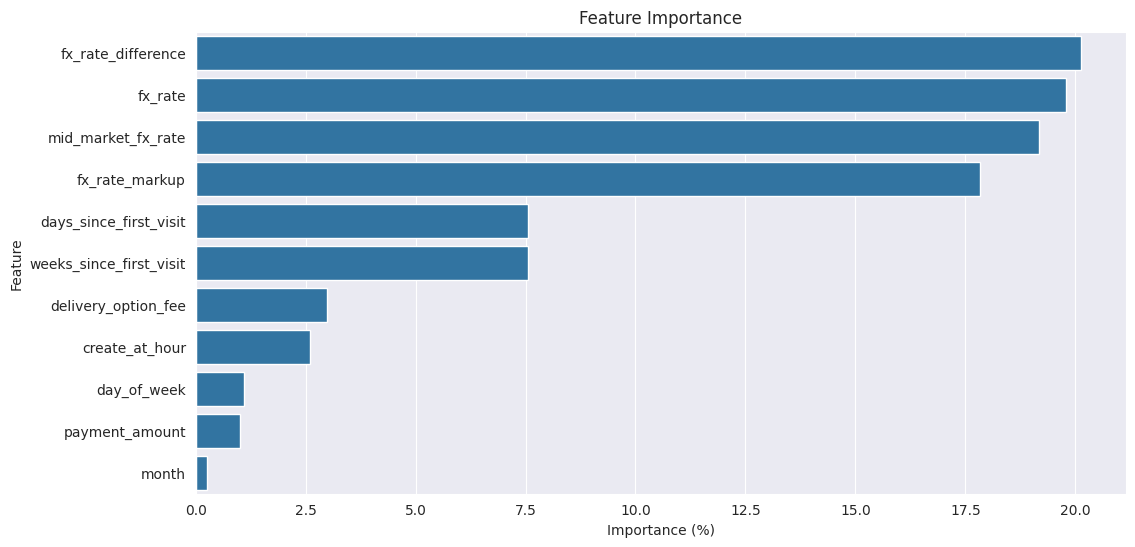

Feature Importance:                     feature  importance
7        fx_rate_difference   20.138198
1                   fx_rate   19.782540
2        mid_market_fx_rate   19.169839
8            fx_rate_markup   17.830476
9    days_since_first_visit    7.557319
10  weeks_since_first_visit    7.557108
3       delivery_option_fee    2.981121
4            create_at_hour    2.595013
6               day_of_week    1.110148
0            payment_amount    1.011066
5                     month    0.267173
Selected features: ['fx_rate_difference', 'fx_rate', 'mid_market_fx_rate', 'fx_rate_markup'], with importance >= 10.0


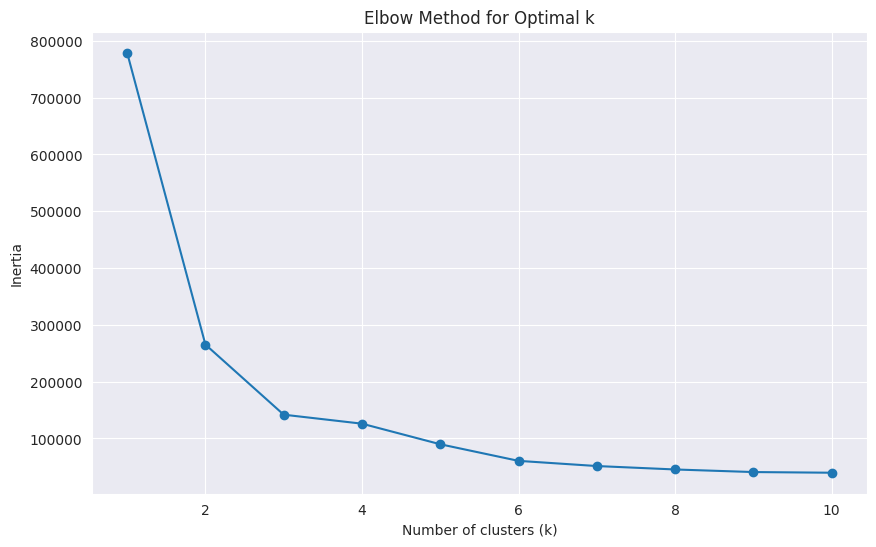

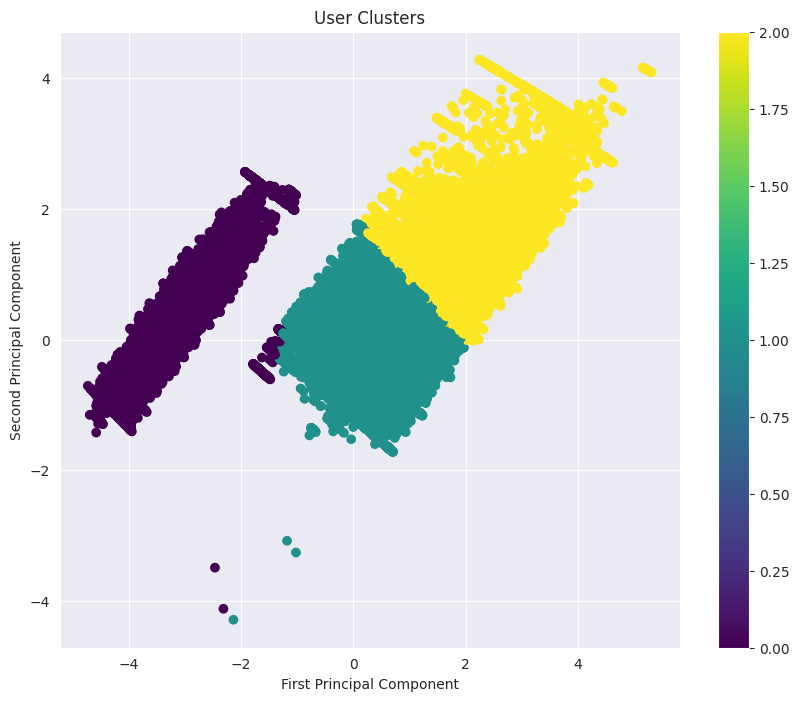


Cluster 0:
       fx_rate_difference       fx_rate  mid_market_fx_rate  fx_rate_markup
count        41012.000000  41012.000000        41012.000000    41012.000000
mean            -1.429486     -1.813652           -1.801196       -1.139622
std              0.449845      0.212083            0.223251        0.668037
min             -2.948812     -2.120896           -2.251676       -3.486168
25%             -1.674830     -1.930022           -1.923114       -1.491273
50%             -1.395981     -1.867693           -1.850855       -1.050155
75%             -1.177554     -1.773579           -1.749264       -0.781339
max              0.128214      0.676811            1.037416        1.038935

Cluster 1:
       fx_rate_difference        fx_rate  mid_market_fx_rate  fx_rate_markup
count       130714.000000  130714.000000       130714.000000   130714.000000
mean             0.137058       0.472032            0.493438        0.017108
std              0.313661       0.381556            0.398273 

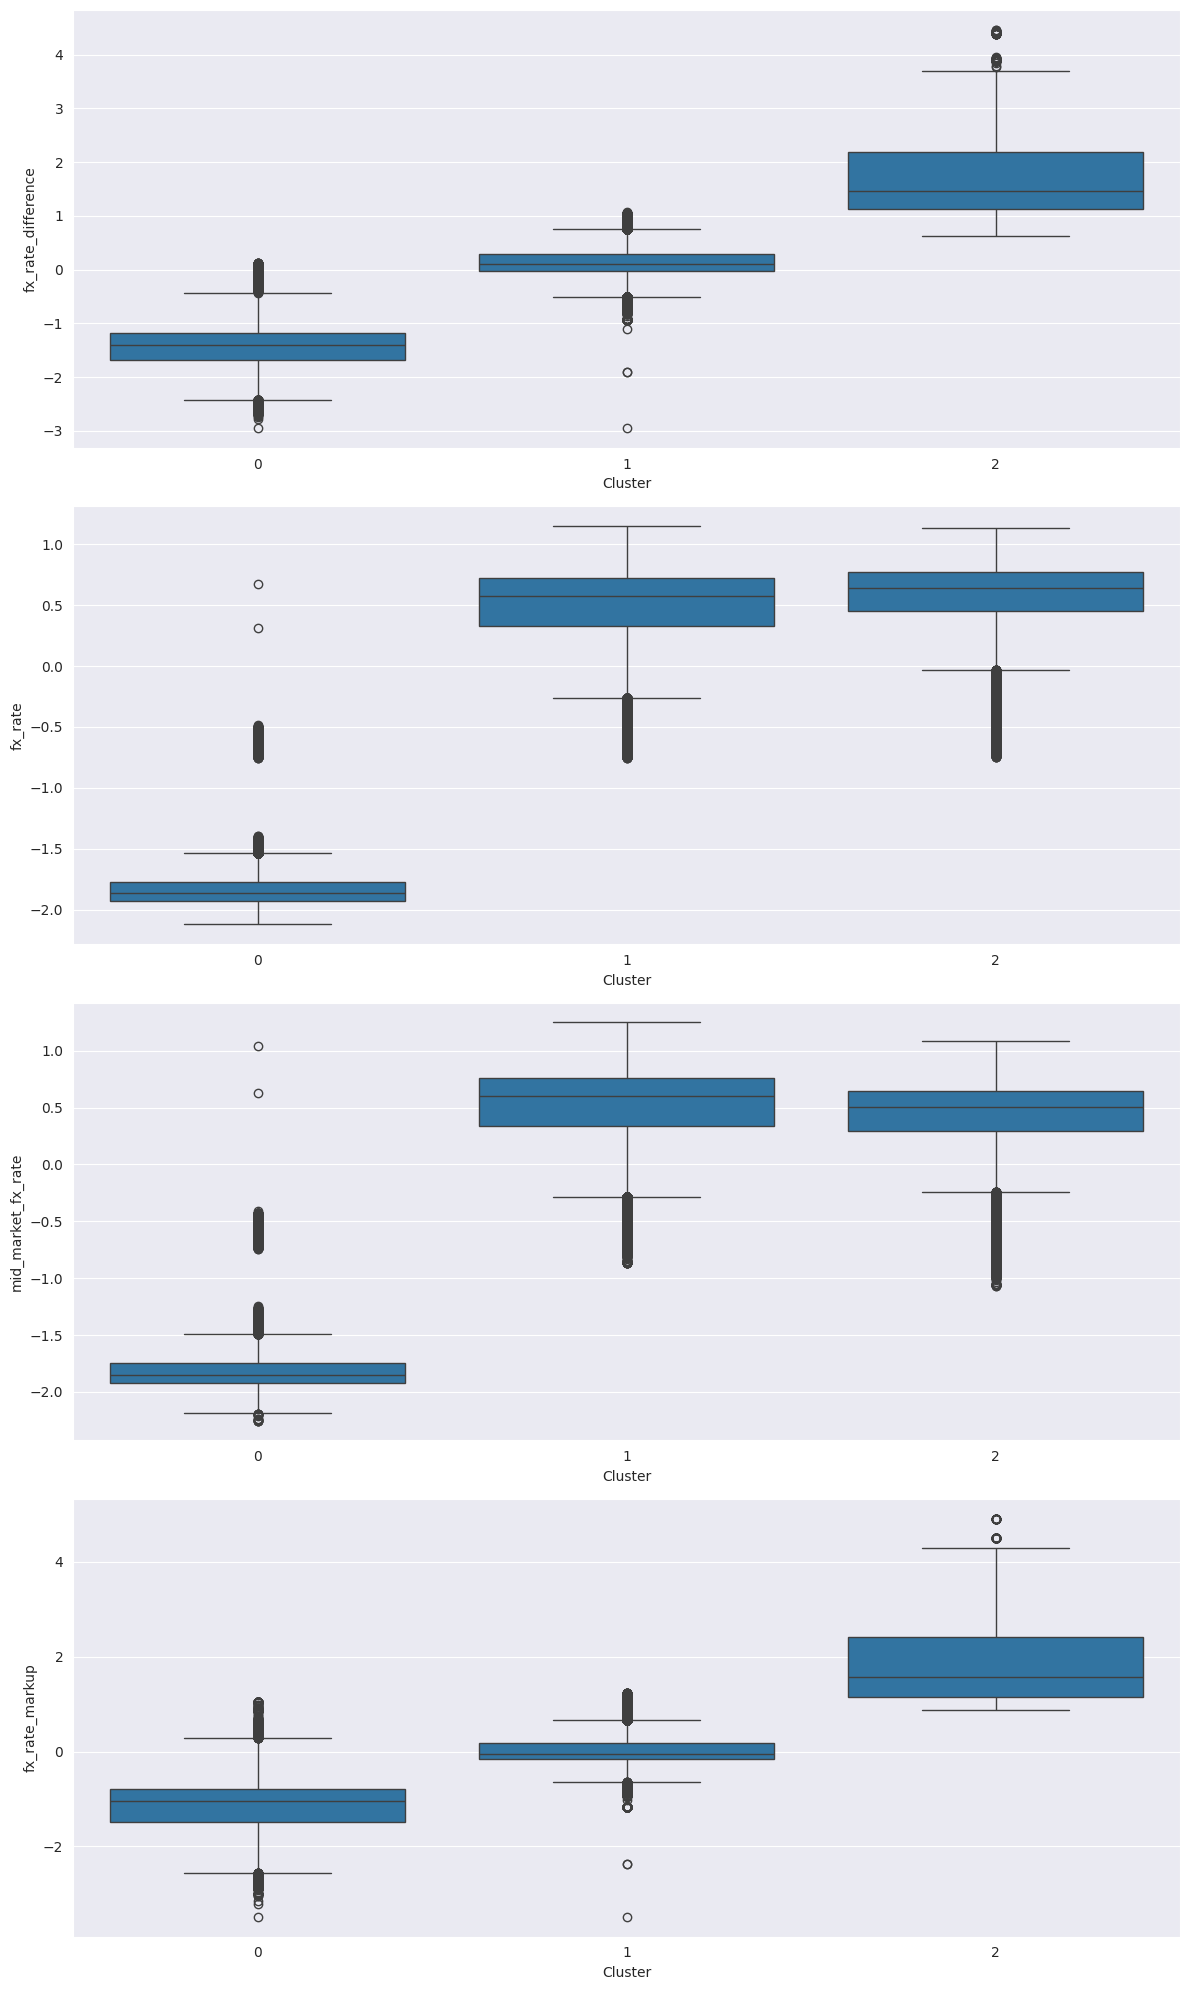

In [77]:
clustering(data_clean, False)

There could be some interesting findings be done after analyzing the clusters more closely. But I can safely say that there are at minimum two distinct clusers (0, 1). The 1 and 2 clusters seem to be alike, but distinct in some metrics.

# Compute the cost  of each transaction (%), show aggregate revenue margin on daily level

In [30]:
def calculate_transaction_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Calculate transaction cost percentage and revenue margin."""
    # Assuming 'fx_rate' is the rate we charge and 'mid_market_fx_rate' is our cost
    df['transaction_cost_percentage'] = ((df['fx_rate'] - df['mid_market_fx_rate']) / df['mid_market_fx_rate']) * 100
    
    # Assuming payment_amount is in the 'from' currency
    df['revenue'] = df['payment_amount'] * (df['fx_rate'] - df['mid_market_fx_rate'])
    
    return df

def aggregate_daily_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Aggregate metrics on a daily level."""
    daily_metrics = df.groupby(df['created_at'].dt.date).agg({
        'transaction_cost_percentage': 'mean',
        'revenue': 'sum',
        'payment_amount': 'sum'
    }).reset_index()
    
    daily_metrics['revenue_margin_percentage'] = (daily_metrics['revenue'] / daily_metrics['payment_amount']) * 100
    
    return daily_metrics

def plot_daily_metrics(daily_metrics: pd.DataFrame) -> None:
    """Plot daily transaction cost percentage and revenue margin."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Transaction Cost Percentage', color='tab:blue')
    ax1.plot(daily_metrics['created_at'], daily_metrics['transaction_cost_percentage'], color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Revenue Margin Percentage', color='tab:orange')
    ax2.plot(daily_metrics['created_at'], daily_metrics['revenue_margin_percentage'], color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    plt.title('Daily Transaction Cost and Revenue Margin Percentages')
    plt.show()

def calculate_1_task(df: pd.DataFrame) -> None:
    df = calculate_transaction_metrics(df)
    
    daily_metrics = aggregate_daily_metrics(df)    
    plot_daily_metrics(daily_metrics)
    
    print("\nSummary Statistics:")
    print(daily_metrics.describe())


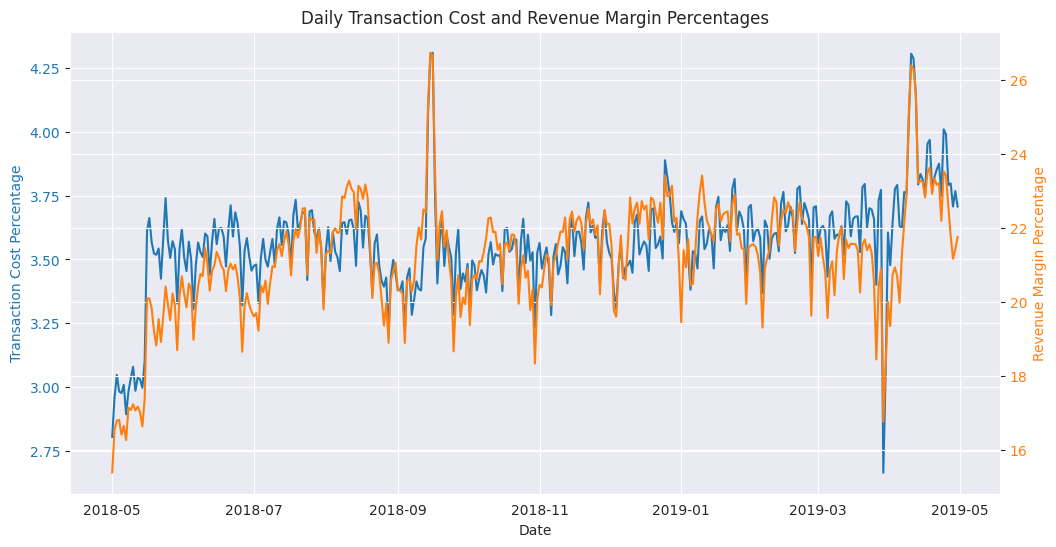


Summary Statistics:
       transaction_cost_percentage        revenue  payment_amount  \
count                   365.000000     365.000000    3.650000e+02   
mean                      3.560628  371784.864705    1.740860e+06   
std                       0.202133  146188.041243    6.342357e+05   
min                       2.662981   64594.140123    3.319619e+05   
25%                       3.476651  273774.335731    1.313850e+06   
50%                       3.574365  349180.933151    1.676771e+06   
75%                       3.658380  466339.756876    2.148315e+06   
max                       4.310950  912352.998112    3.936432e+06   

       revenue_margin_percentage  
count                 365.000000  
mean                   21.236634  
std                     1.584685  
min                    15.389676  
25%                    20.462851  
50%                    21.407089  
75%                    22.178473  
max                    26.744060  


In [31]:
calculate_1_task(data_clean)

# Model

In [45]:
def prepare_data(df: pd.DataFrame, 
                 agg: dict) -> pd.DataFrame:
    """Load and prepare data for VAR analysis."""
    df = df.set_index('created_at')
    df = df.resample('D').agg(agg)
    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=list(agg_dict.keys()), index=df.index)
    return df_scaled

def test_stationarity(series):
    """Perform Augmented Dickey-Fuller test for stationarity."""
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

def fit_var_model(data):
    """Fit VAR model to the data."""
    model = VAR(data)
    results = model.fit()
    return results

def granger_causality(results, variables):
    """Perform Granger causality tests."""
    for i in range(len(variables)):
        for j in range(len(variables)):
            if i != j:
                test_result = results.test_causality(variables[j], [variables[i]], kind='f')
                print(f"{variables[i]} Granger-causes {variables[j]}: p-value = {test_result.pvalue:.4f}")
                
def impulse_response_analysis(results):
    """Perform impulse response analysis."""
    irf = results.irf(10)  # 10 periods ahead
    irf.plot(orth=False)
    plt.show()

def main(df: pd.DataFrame, agg_dict: dict) -> None:
    data = prepare_data(df, agg_dict)
    
    for key in agg_dict:
        print(f"\nStationarity Test for {key}:")
        test_stationarity(data[key])

    var_results = fit_var_model(data)
    print(var_results.summary())

    granger_causality(var_results, data.columns)

    impulse_response_analysis(var_results)

In [46]:
agg_dict = {'transaction_cost_percentage': 'mean',
            'payment_amount': 'mean'  # Going to say that payment amount represent activity
            }


Stationarity Test for transaction_cost_percentage:
ADF Statistic: -4.956289201205493
p-value: 2.7065663368771592e-05
Critical Values:
	1%: -3.44880082033912
	5%: -2.869670179576637
	10%: -2.5711012838861036

Stationarity Test for payment_amount:
ADF Statistic: -5.534522198329569
p-value: 1.7569591762393256e-06
Critical Values:
	1%: -3.4491725955218655
	5%: -2.8698334971428574
	10%: -2.5711883591836733
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 02, Aug, 2024
Time:                     08:25:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.56511
Nobs:                     364.000    HQIC:                  -1.60382
Log likelihood:          -730.446    FPE:                   0.196057
AIC:                     -1.62935    Det(Omega_mle):        0.192865
--------------------------------------------------------------------
Resul

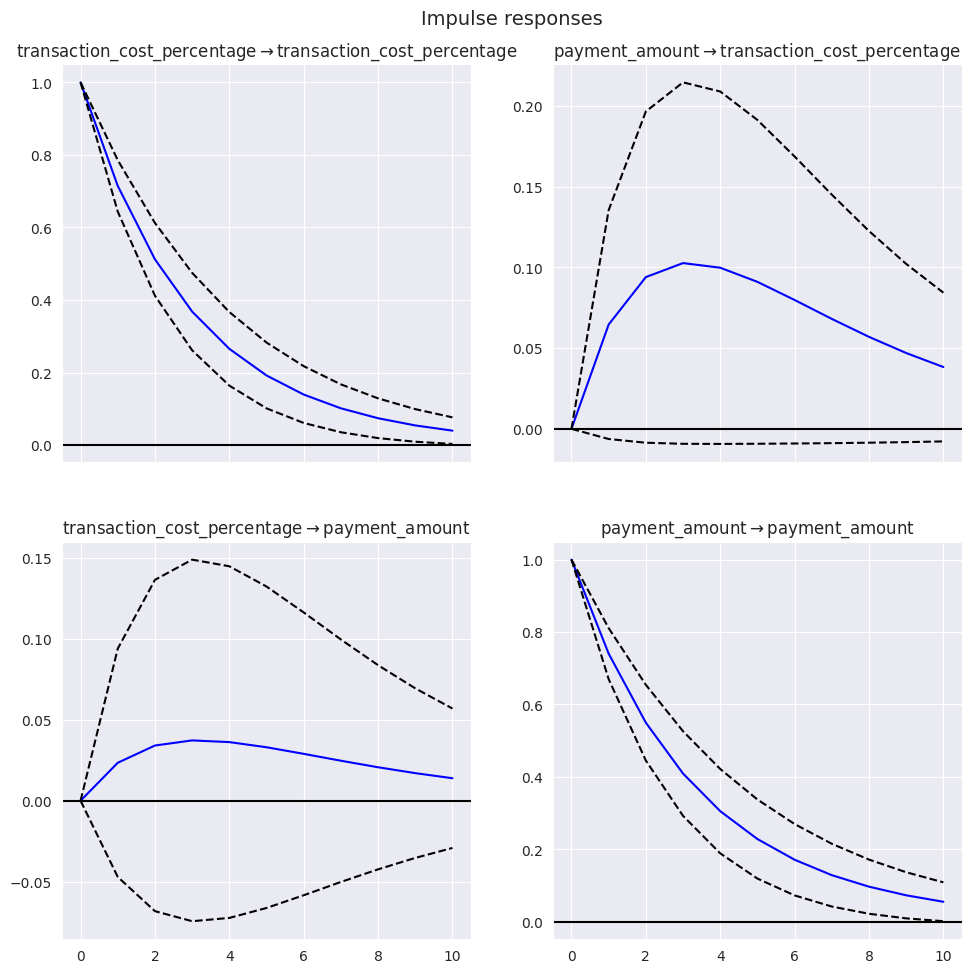

In [47]:
main(data_clean, agg_dict)

Summary of the results: 
1.  Stationarity Tests:
    - Both Transaction Cost Percentage and Payment Amount are stationary (p-values < 0.05).
    - This indicates that both series are suitable for VAR modeling without differencing.
2. Transaction Cost Percentage Equation:
    - Strong autoregressive effect (coefficient: 0.714560, p-value: 0.000).
    - Weak, marginally significant effect from Payment Amount (coefficient: 0.064608, p-value: 0.074).
    - Constant term is not significant (p-value: 0.745).
3. Payment Amount Equation:
    - Strong autoregressive effect (coefficient: 0.740388, p-value: 0.000).
    - No significant effect from Transaction Cost Percentage (coefficient: 0.023422, p-value: 0.515).
    - Constant term is not significant (p-value: 0.971)
4. Granger Causality:
    - Transaction Cost Percentage does not Granger-cause Payment Amount (p-value: 0.5148).
    - Payment Amount marginally Granger-causes Transaction Cost Percentage (p-value: 0.0746).
5. Key Insights:
    - Both variables show strong persistence (high autoregressive coefficients).
    - There's weak evidence of Payment Amount influencing Transaction Cost Percentage.
    - No evidence of Transaction Cost Percentage influencing Payment Amount.
    - The relationship between the variables is weaker than suggested by the initial correlation of residuals.
6. Model Limitations:
    - The model explains a significant portion of the variance but there's still unexplained variation.
    - The constant terms are not significant, suggesting the model might be improved by removing them.

These results suggest that while there's some relationship between Transaction Cost Percentage and Payment Amount, it's primarily driven by their own past values rather than strong cross-variable effects.

# fx_rate impact on activity


Stationarity Test for fx_rate:
ADF Statistic: -2.5153361035630453
p-value: 0.11178733574983224
Critical Values:
	1%: -3.449336554273722
	5%: -2.8699055166063085
	10%: -2.571226758215748

Stationarity Test for payment_amount:
ADF Statistic: -5.534522198329569
p-value: 1.7569591762393256e-06
Critical Values:
	1%: -3.4491725955218655
	5%: -2.8698334971428574
	10%: -2.5711883591836733
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 02, Aug, 2024
Time:                     08:26:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.88936
Nobs:                     364.000    HQIC:                  -2.92807
Log likelihood:          -489.432    FPE:                  0.0521517
AIC:                     -2.95360    Det(Omega_mle):       0.0513025
--------------------------------------------------------------------
Results for equation fx_ra

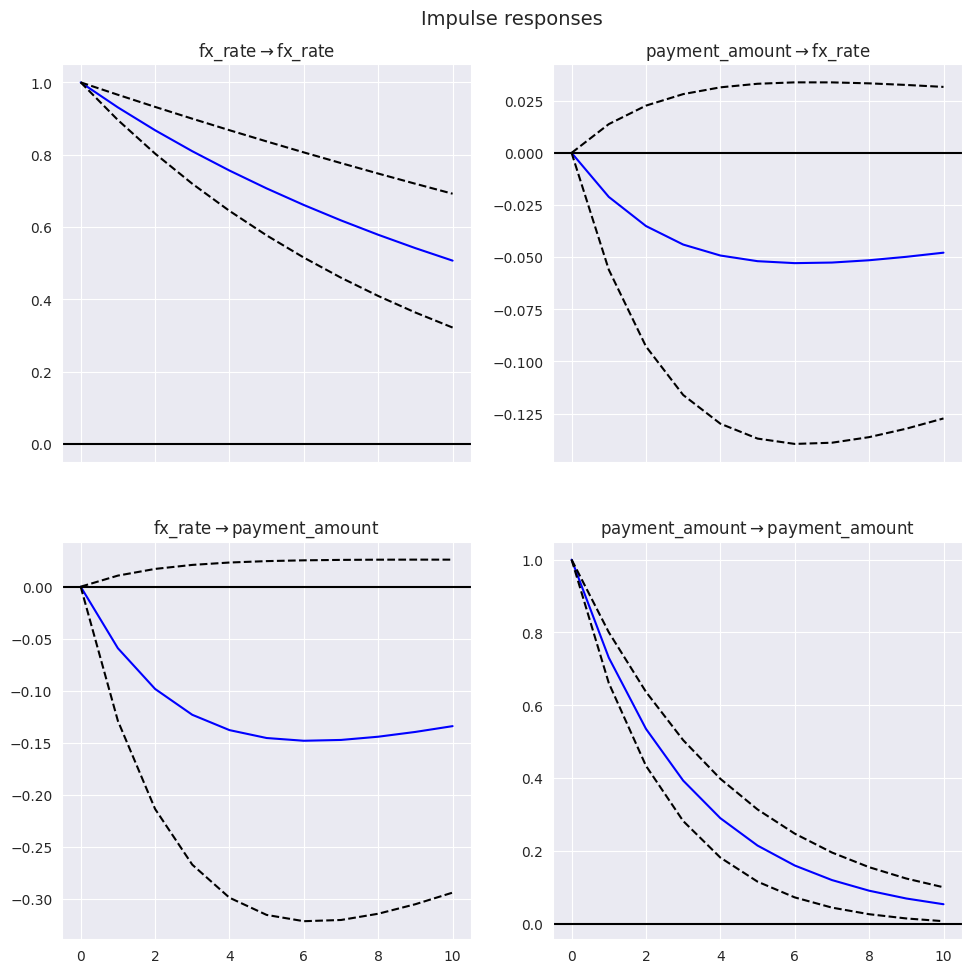

In [48]:
agg_dict = {'fx_rate': 'mean',
            'payment_amount': 'mean'  # Going to say that payment amount represent activity
            }

main(data_clean, agg_dict)


Summary:
1. There is weak evidence of fx_rate impacting activity (payment_amount):
    - The coefficient in the payment_amount equation is negative (-0.059086) and marginally significant (p-value: 0.097)
    - The Granger causality test also shows marginal evidence (p-value: 0.0972)
2. The impact, if present, appears to be relatively small:
    - The coefficient magnitude is small compared to the autoregressive effect of payment_amount itself
    - The correlation between residuals is weak (0.140010)
3. Both variables show strong persistence (high autoregressive coefficients), especially fx_rate
4. The non-stationarity of fx_rate could be a concern for the validity of the VAR model results